<a href="https://colab.research.google.com/github/HagarIbrahiem/NLP_Topic_Modeling/blob/main/Topic_Modeling_for_Arabic_short_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

gogogo

# Libs

In [10]:
'''
!pip install --upgrade pip
!pip install fastapi==0.68.0 kaleido==0.2.1 python-multipart==0.0.5 uvicorn==0.15.0 pandas==1.5.3
!pip install numpy==1.25.4
!pip install tmplot
!pip install python-bidi
!pip install arabic_reshaper
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install bitermplus
!pip install qalsadi
!pip install pyLDAvis
!pip install tomotopy

'''

'\n!pip install --upgrade pip\n!pip install fastapi==0.68.0 kaleido==0.2.1 python-multipart==0.0.5 uvicorn==0.15.0 pandas==1.5.3\n!pip install numpy==1.25.4\n!pip install tmplot\n!pip install python-bidi\n!pip install arabic_reshaper\n!pip install git+https://github.com/rwalk/gsdmm.git\n!pip install bitermplus\n!pip install qalsadi\n!pip install pyLDAvis\n!pip install tomotopy\n\n'

In [11]:
#Base and Cleaning
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from pprint import pprint
import pip
import setuptools
import tmplot as tmp



# loading some necessary packages
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import ISRIStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from bidi.algorithm import get_display
import arabic_reshaper


from gensim.models.nmf import Nmf as GensimNmf
from gsdmm import MovieGroupProcess
from gensim.models import AuthorTopicModel
import tomotopy as tp
from gensim import models
from statistics import mean
import bitermplus as btm
from gensim.models import LdaSeqModel
import qalsadi.lemmatizer
from gensim.models import HdpModel


# Visualizations
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models

In [12]:
# Global Variables
TXT_INDX = 1500

# Load Data

In [13]:
data = pd.read_csv('tickets-commentcitizens.csv',index_col=0)
data.head()

,ID,citizenComment
0,7628.0,السلام عليكم\nلدي طلب رقم 746855 لم تتغير حالت...
1,7768.0,عدم الاستطاعة باضافة العقد الموثق
2,7771.0,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق
3,7796.0,هناك حساب فقد لا نتزكر كلمة السر الرقم القومى...
4,7830.0,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...


In [14]:
data.rename(columns = {'citizenComment':'text'}, inplace = True)
data.drop(['ID'], axis=1)

,text
0,السلام عليكم\nلدي طلب رقم 746855 لم تتغير حالت...
1,عدم الاستطاعة باضافة العقد الموثق
2,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق
3,هناك حساب فقد لا نتزكر كلمة السر الرقم القومى...
4,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...
...,...
47736,السلام عليكم\nنظرا ا للظروف التي تحدث والانقطا...
47737,إلغاء الطلب رقم 3579676\nلدواعي السفر وعدم الج...
47738,بعد تركيب العداد تفاجأت بأنه إنتاج 2021 في حين...
47739,كم سعر الرسوم ؟؟؟؟؟؟


In [15]:
len(data)

47741

# Data Pre-processing
Our goal in the data pre-processing stage is to convert sentences into words, convert words to
their root and removing words that are too common or too irrelevant to the purpose of our
topic modeling project,We used the following techniques to reach our goal:


- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
- Words are lemmatized and stemmed — words in the third person are changed to first person and verbs in past and future tenses are changed into the present and are reduced to their root form.

## Removing punctuation

In [16]:
data['text'][TXT_INDX] #1000

'بعد السلام عليكم \nتلقيت مكالمة من أحد موظفى الشركة الكرام للسؤال عن وجودى بمقر إقامتى لإجراء المقايسة اللازمة وتوجهت لمقر الشقة المطلوب تركيب العداد بها حيث أنى غير مقيم فى هذا المكان أغلب الوقت .\nفوجئت بالموظف المذكور عند معاودة اتصالة به بأن الشقة المطلوب تركيب عداد بها لا ينطبق عليها الشروط وأنه لابد من الإنتهاء من واجهة العقار وكذا التشطيبات مع تأكيدى له بأن وقف إجراء تلك التشطيبات قرار دولة وليس لى كمالك للوحدة داخل العقار محل الدراسة .\nلذا أرجو الإفادة وسرعة عمل المقايسة المطلوبة وتركيب العداد لأنه ليس من العدل أن أسدد ما يقرب من 500 جنيه شهرياً لمكان لا أقيم به .\nوتجدون سيادتكم مرفقاً مع هذا صورة من آخر سداد للممارسة .\nمع وافر الشكر والتقدير \nرضا شحات على خطاب'

In [17]:

data['text'] = data['text'].map(lambda x: x.replace("#", " ").replace("_", " ").replace("|", " ").replace("؟", "").replace("!", " ")
                                          .replace('\"', " ").replace(';', "").replace(':', "").replace('(', "").replace(')', "")
                                          .replace('،', " ").replace('-', " ").replace('…', "").replace('\n', "").replace('.', ""))

In [18]:
data['text'][TXT_INDX]

'بعد السلام عليكم تلقيت مكالمة من أحد موظفى الشركة الكرام للسؤال عن وجودى بمقر إقامتى لإجراء المقايسة اللازمة وتوجهت لمقر الشقة المطلوب تركيب العداد بها حيث أنى غير مقيم فى هذا المكان أغلب الوقت فوجئت بالموظف المذكور عند معاودة اتصالة به بأن الشقة المطلوب تركيب عداد بها لا ينطبق عليها الشروط وأنه لابد من الإنتهاء من واجهة العقار وكذا التشطيبات مع تأكيدى له بأن وقف إجراء تلك التشطيبات قرار دولة وليس لى كمالك للوحدة داخل العقار محل الدراسة لذا أرجو الإفادة وسرعة عمل المقايسة المطلوبة وتركيب العداد لأنه ليس من العدل أن أسدد ما يقرب من 500 جنيه شهرياً لمكان لا أقيم به وتجدون سيادتكم مرفقاً مع هذا صورة من آخر سداد للممارسة مع وافر الشكر والتقدير رضا شحات على خطاب'

## Remove StopWords

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# let's check if nltk contains stopwords for arabic datasets
stopwords.fileids()

['arabic',
 'azerbaijani',
 'basque',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [21]:
stopwords_list = stopwords.words('arabic')
print(stopwords_list)

['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل', 'على', 'عليك', 'عليه', 'عما', 'عن', 'عند', 'غير', 'فإذا', 'فإن', 'فلا', 'فمن', 'في', 'فيم', 'فيما', 'فيه', 'فيها', '

In [22]:
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))
data

,ID,text
0,7628.0,السلام عليكملدي طلب رقم 746855 تتغير حالته 14 ...
1,7768.0,عدم الاستطاعة باضافة العقد الموثق
2,7771.0,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق
3,7796.0,حساب فقد نتزكر كلمة السر الرقم القومى الخاص با...
4,7830.0,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...
...,...,...
47736,51684.0,السلام عليكمنظرا للظروف تحدث والانقطاع المستمر...
47737,51631.0,إلغاء الطلب رقم 3579676لدواعي السفر وعدم الجاه...
47738,51659.0,تركيب العداد تفاجأت بأنه إنتاج 2021 جارى ركب ع...
47739,51701.0,سعر الرسوم


## lemmatization

- The library used for the lemmatization in our case is [Qalsadi](https://pypi.org/project/qalsadi/)

In [23]:
def lemmatize_stemming(text):
    return qalsadi.lemmatizer.Lemmatizer().lemmatize(text)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stopwords_list and len(token) > 3:
            emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
            emoji_pattern.sub(r'', token)
            result.append(lemmatize_stemming(token))
    return result

In [24]:
data_text = data[["text"]]
data_text["index"] = data_text.index
documents = data_text
documents

,text,index
0,السلام عليكملدي طلب رقم 746855 تتغير حالته 14 ...,0
1,عدم الاستطاعة باضافة العقد الموثق,1
2,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق,2
3,حساب فقد نتزكر كلمة السر الرقم القومى الخاص با...,3
4,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...,4
...,...,...
47736,السلام عليكمنظرا للظروف تحدث والانقطاع المستمر...,47736
47737,إلغاء الطلب رقم 3579676لدواعي السفر وعدم الجاه...,47737
47738,تركيب العداد تفاجأت بأنه إنتاج 2021 جارى ركب ع...,47738
47739,سعر الرسوم,47739


In [25]:
# Checking The first row of the column text
data["text"][TXT_INDX]

'السلام عليكم تلقيت مكالمة موظفى الشركة الكرام للسؤال وجودى بمقر إقامتى لإجراء المقايسة اللازمة وتوجهت لمقر الشقة المطلوب تركيب العداد مقيم فى المكان أغلب الوقت فوجئت بالموظف المذكور معاودة اتصالة بأن الشقة المطلوب تركيب عداد ينطبق عليها الشروط وأنه لابد الإنتهاء واجهة العقار وكذا التشطيبات تأكيدى بأن وقف إجراء التشطيبات قرار دولة وليس لى كمالك للوحدة داخل العقار محل الدراسة لذا أرجو الإفادة وسرعة عمل المقايسة المطلوبة وتركيب العداد لأنه العدل أسدد يقرب 500 شهرياً لمكان أقيم وتجدون سيادتكم مرفقاً صورة آخر سداد للممارسة وافر الشكر والتقدير رضا شحات خطاب'

In [26]:
doc_sample = documents[documents['index'] == TXT_INDX].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


original document: 
['السلام', 'عليكم', 'تلقيت', 'مكالمة', 'موظفى', 'الشركة', 'الكرام', 'للسؤال', 'وجودى', 'بمقر', 'إقامتى', 'لإجراء', 'المقايسة', 'اللازمة', 'وتوجهت', 'لمقر', 'الشقة', 'المطلوب', 'تركيب', 'العداد', 'مقيم', 'فى', 'المكان', 'أغلب', 'الوقت', 'فوجئت', 'بالموظف', 'المذكور', 'معاودة', 'اتصالة', 'بأن', 'الشقة', 'المطلوب', 'تركيب', 'عداد', 'ينطبق', 'عليها', 'الشروط', 'وأنه', 'لابد', 'الإنتهاء', 'واجهة', 'العقار', 'وكذا', 'التشطيبات', 'تأكيدى', 'بأن', 'وقف', 'إجراء', 'التشطيبات', 'قرار', 'دولة', 'وليس', 'لى', 'كمالك', 'للوحدة', 'داخل', 'العقار', 'محل', 'الدراسة', 'لذا', 'أرجو', 'الإفادة', 'وسرعة', 'عمل', 'المقايسة', 'المطلوبة', 'وتركيب', 'العداد', 'لأنه', 'العدل', 'أسدد', 'يقرب', '500', 'شهرياً', 'لمكان', 'أقيم', 'وتجدون', 'سيادتكم', 'مرفقاً', 'صورة', 'آخر', 'سداد', 'للممارسة', 'وافر', 'الشكر', 'والتقدير', 'رضا', 'شحات', 'خطاب']


 tokenized and lemmatized document: 
['سلام', 'على', 'تلقى', 'مكالم', 'موظفى', 'شرك', 'كرام', 'سؤال', 'جودى', 'مقر', 'إقامتى', 'إجراء', 'مقايسة', 'لا

## Drop Missing Values

In [27]:
data.isnull().sum()

ID      0
text    0
dtype: int64

P.S. In this next part we will be using only 10 samples instead of the whole dataset to speed up the process

In [30]:
documents = documents[:100]
documents

,text,index
0,السلام عليكملدي طلب رقم 746855 تتغير حالته 14 ...,0
1,عدم الاستطاعة باضافة العقد الموثق,1
2,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق,2
3,حساب فقد نتزكر كلمة السر الرقم القومى الخاص با...,3
4,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...,4
5,تاخرت المعاينة عنى علما بان غيرى اتته المعاينة...,5
6,عدم استطاعتي رفع عقد ايجار موثق,6
7,يرجي التكرم بالافاده الطلب المقدم بتاريخ 10 اغ...,7
8,لقد تقدمت بطلب تركيب عداد كودى وتمت كتابة الرق...,8
9,يتم تغير حالة الطلب اكثر شهرين الرجاء تغير حال...,9


In [31]:
for txt in documents['text']:
  print(preprocess(txt))

['سلام', 'عليكملدي', 'تغير', 'حال', 'دراس', 'فن', 'رجاء', 'الافاده', 'حال', 'طلب', 'توقف', 'شكر']
['استطاعة', 'باضافة', 'عقد', 'موثق']
['استطاعة', 'تعديل', 'طلب', 'واضافة', 'عقد', 'موثق']
['حساب', 'نتزكر', 'كلم', 'سر', 'رقم', 'قومى', 'الخاص', 'حساب']
['سلام', 'على', 'الاول', 'عمل', 'اتاخر', 'كتير', 'عمل', 'تانى', 'رد', 'استكمال', 'بيان', 'وقف', 'عمل', 'تال', 'اتقبل', 'سرع', 'عاوز', 'حذف', 'خلى']
['تاخرت', 'معاين', 'علم', 'غيرى', 'اتته', 'معاين', 'عدى', 'مد', 'زمن']
['استطاعة', 'ايجار', 'موثق']
['رجى', 'تكرم', 'بالافاده', 'طلب', 'مقدم', 'تاريخ', 'اغسطس', 'رقم', 'طلب', 'للدراسه', 'الفنيه', 'الافاده', 'ال', 'تركيب']
['تقدم', 'طلب', 'تركيب', 'عداد', 'ودى', 'أمات', 'كتاب', 'رقم', 'قومى', 'تسبب', 'قبول', 'طلب', 'رجا', 'تصحيح', 'رقم', 'قومى', 'الخاص', 'تفعيل', 'طلب', 'الخاص', 'مرفق', 'صور', 'بطاقة', 'رقم', 'قومى']
['تغير', 'حال', 'طلب', 'كثر', 'شهر', 'رجاء', 'تغير', 'حال', 'طلب', 'انتهاء', 'المده']


In [32]:
processed_docs = documents['text'].map(preprocess)
processed_docs

0    [سلام, عليكملدي, تغير, حال, دراس, فن, رجاء, ال...
1                         [استطاعة, باضافة, عقد, موثق]
2             [استطاعة, تعديل, طلب, واضافة, عقد, موثق]
3       [حساب, نتزكر, كلم, سر, رقم, قومى, الخاص, حساب]
4    [سلام, على, الاول, عمل, اتاخر, كتير, عمل, تانى...
5    [تاخرت, معاين, علم, غيرى, اتته, معاين, عدى, مد...
6                               [استطاعة, ايجار, موثق]
7    [رجى, تكرم, بالافاده, طلب, مقدم, تاريخ, اغسطس,...
8    [تقدم, طلب, تركيب, عداد, ودى, أمات, كتاب, رقم,...
9    [تغير, حال, طلب, كثر, شهر, رجاء, تغير, حال, طل...
Name: text, dtype: object

In [33]:
type(processed_docs)

pandas.core.series.Series

## Bag Of Words

### Bag of words:

Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [34]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [35]:
print(dictionary)

Dictionary<76 unique tokens: ['الافاده', 'تغير', 'توقف', 'حال', 'دراس']...>


In [36]:
count = 0
for k, v in dictionary.iteritems():
    print(v, k)
    count += 1
    if count > 10:
        break

الافاده 0
تغير 1
توقف 2
حال 3
دراس 4
رجاء 5
سلام 6
شكر 7
طلب 8
عليكملدي 9
فن 10



- read more about filter_extremes (https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes)

In [37]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

bow_corpus[1]

[(11, 1), (12, 1), (13, 1), (14, 1)]

In [38]:
type(bow_corpus)

list

In [39]:
# SAmple of Topic 01
bow_doc_01 = bow_corpus[1]
for i in range(len(bow_doc_01)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_01[i][0],
                                                     dictionary[bow_doc_01[i][0]],
                                                     bow_doc_01[i][1]))

Word 11 ("استطاعة") appears 1 time.
Word 12 ("باضافة") appears 1 time.
Word 13 ("عقد") appears 1 time.
Word 14 ("موثق") appears 1 time.


- Read More about  [BAG OF WORDS](https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm)

### TF-IDF:



In [40]:

tfidf = gensim.models.TfidfModel(bow_corpus)

In [41]:
corpus_tfidf = tfidf[bow_corpus]

In [42]:
type(corpus_tfidf)

gensim.interfaces.TransformedCorpus

In [43]:
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2330017606421678),
 (1, 0.2330017606421678),
 (2, 0.33335015694057724),
 (3, 0.4660035212843356),
 (4, 0.33335015694057724),
 (5, 0.2330017606421678),
 (6, 0.2330017606421678),
 (7, 0.33335015694057724),
 (8, 0.1003483962984094),
 (9, 0.33335015694057724),
 (10, 0.33335015694057724)]


In [44]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Modeling Part:


- In this section we are going to use the topic modeling algorithms and calculte the most important measure "coherence"

# 1- Latent Dirichlet Allocation( LDA)

In [45]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [46]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.110*"طلب" + 0.084*"رقم" + 0.084*"قومى" + 0.057*"الخاص" + 0.030*"تقدم" + 0.030*"عداد" + 0.030*"تصحيح" + 0.030*"أمات" + 0.030*"تركيب" + 0.030*"ودى"
Topic: 1 
Words: 0.087*"عمل" + 0.059*"معاين" + 0.031*"وقف" + 0.031*"اتقبل" + 0.031*"الاول" + 0.031*"استكمال" + 0.031*"كتير" + 0.031*"خلى" + 0.031*"سرع" + 0.031*"اتاخر"
Topic: 2 
Words: 0.013*"موثق" + 0.013*"استطاعة" + 0.013*"عقد" + 0.013*"طلب" + 0.013*"ايجار" + 0.013*"رقم" + 0.013*"باضافة" + 0.013*"تغير" + 0.013*"حال" + 0.013*"حساب"
Topic: 3 
Words: 0.013*"موثق" + 0.013*"طلب" + 0.013*"استطاعة" + 0.013*"عقد" + 0.013*"رقم" + 0.013*"ايجار" + 0.013*"حال" + 0.013*"رجاء" + 0.013*"تغير" + 0.013*"باضافة"
Topic: 4 
Words: 0.013*"استطاعة" + 0.013*"طلب" + 0.013*"موثق" + 0.013*"عقد" + 0.013*"ايجار" + 0.013*"رقم" + 0.013*"باضافة" + 0.013*"حال" + 0.013*"قومى" + 0.013*"حساب"
Topic: 5 
Words: 0.164*"استطاعة" + 0.164*"موثق" + 0.094*"عقد" + 0.068*"باضافة" + 0.068*"ايجار" + 0.006*"تعديل" + 0.006*"واضافة" + 0.006*"طلب" + 0.006*"رقم" + 0.006*"ح

### LDA Coherence with u_mass

In [47]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, dictionary=dictionary, coherence='u_mass',corpus=bow_corpus)
coherence_lda_uMass = coherence_model_lda.get_coherence()
print('\nCoherence Score with u_mass: ', coherence_lda_uMass)


Coherence Score with u_mass:  -15.796892798958657


### LDA cohernece with c_v

In [48]:

# Compute Coherence Score with tfidf and u_mass parameter
coherence_model_lda = CoherenceModel(model=lda_model, dictionary=dictionary, coherence='c_v', texts =processed_docs  )
coherence_lda_cv = coherence_model_lda.get_coherence()
print('\nCoherence Score with c_v: ', coherence_lda_cv)


Coherence Score with c_v:  0.5676901999545799


### LDA Cohernece with c_npmi

In [49]:
#corpus_tfidf
# Compute Coherence Score with tfidf and u_mass parameter
coherence_model_lda = CoherenceModel(model=lda_model, dictionary=dictionary, coherence='c_npmi', texts =processed_docs  )
coherence_lda_npmi = coherence_model_lda.get_coherence()
print('\nCoherence Score with c_npmi: ', coherence_lda_npmi)


Coherence Score with c_npmi:  -0.34658886073215867


### LDA Cohernece with C_uci

In [50]:

coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_uci')
coherence_lda_uci = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_uci)


Coherence Score:  -14.014338983535703


### Optimal number of topics LDA

The last step is to find the optimal number of topics.We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

read more about how to implement this step: https://datascience.oneoffcoder.com/topic-modeling-gensim.html

In [51]:
results = []

for t in range(2,10):
    lda_model = gensim.models.LdaMulticore(bow_corpus, id2word=dictionary, passes=2, workers=2,num_topics=t)
    corpus_lda = lda_model[corpus_tfidf]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

In [52]:
results

,topic,score
0,2,-1.817830
1,3,-1.939019
2,4,-3.417521
3,5,-3.053955
4,6,-3.587185
5,7,-3.781087
6,8,-4.926320
7,9,-4.718280


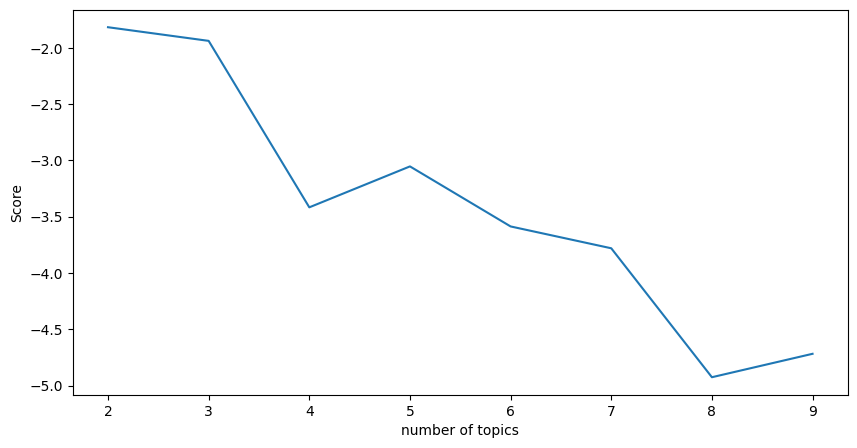

In [53]:
plt.figure(figsize = (10,5))
s = pd.Series(results.score.values, index=results.topic.values)
plt.xlabel("number of topics")
plt.ylabel("Score")
_ = s.plot()

In [54]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.216096  0.005936       1        1  31.724002
5      0.074476  0.139268       2        1  29.842575
6      0.079434 -0.111893       3        1  21.783296
7      0.088001  0.010446       4        1  10.178201
4      0.020026 -0.038237       5        1   2.916085
8     -0.033099  0.005274       6        1   0.888963
3      0.004254 -0.021327       7        1   0.888961
0     -0.008498  0.005266       8        1   0.888958
1     -0.008498  0.005266       9        1   0.888958, topic_info=       Term      Freq     Total Category  logprob  loglift
3       حال  3.000000  3.000000  Default  30.0000  30.0000
1      تغير  2.000000  2.000000  Default  29.0000  29.0000
37      عمل  2.000000  2.000000  Default  28.0000  28.0000
11  استطاعة  1.000000  1.000000  Default  27.0000  27.0000
14     موثق  1.000000  1.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
6      سلام  0.012983  1.888525   Topic9  -4.3307  -0.2570
42      زمن  0.012983  1.196172   Topic9  -4.3307   0.1997
43      عدى  0.012983  1.196172   Topic9  -4.3307   0.1997
54    تركيب  0.012983  1.977712   Topic9  -4.3307  -0.3031
40     اتته  0.012983  1.196174   Topic9  -4.3307   0.1997

[404 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
59        2  0.842814     أمات
24        3  0.907955    اتاخر
40        2  0.835999     اتته
25        3  0.912295    اتقبل
11        3  0.507895  استطاعة
...     ...       ...      ...
14        4  0.507894     موثق
23        4  1.066588    نتزكر
16        3  0.871050   واضافة
71        2  0.842838      ودى
39        3  0.914922      وقف

[86 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 7, 8, 5, 9, 4, 1, 2])

# 2- LDA Sequence

In [ ]:

ldaseq = LdaSeqModel(corpus=bow_corpus, id2word=dictionary, time_slice=[438, 430, 456], num_topics=5)


In [ ]:
ldaseq.print_topics(time=0)

In [ ]:
ldaseq.print_topic_times(topic=0) # evolution of 1st topic

### LDA seq cohererence with CV

In [ ]:


# we just have to specify the time-slice we want to find coherence for.

topics_dtm = ldaseq.dtm_coherence(time=0)

# running u_mass coherence on our models
dtm = CoherenceModel(topics=topics_dtm, corpus=bow_corpus,texts=processed_docs, dictionary=dictionary, coherence='c_v')
ldaseq_cv=dtm.get_coherence()


print ("Coherence score by cv: ", ldaseq_cv)



### LDA seq coherence with u_mass

In [ ]:


# we just have to specify the time-slice we want to find coherence for.

topics_dtm = ldaseq.dtm_coherence(time=0)

# running u_mass coherence on our models
dtm = CoherenceModel(topics=topics_dtm, corpus=bow_corpus,texts=processed_docs, dictionary=dictionary, coherence='u_mass')
ldaseq_umass=dtm.get_coherence()

print ("Coherence score by U_MASS: ",ldaseq_umass )


### LDA seq coherence with C_uci

In [ ]:

# we just have to specify the time-slice we want to find coherence for.

topics_dtm = ldaseq.dtm_coherence(time=0)

# running u_mass coherence on our models
dtm = CoherenceModel(topics=topics_dtm, corpus=bow_corpus,texts=processed_docs, dictionary=dictionary, coherence='c_uci')
ldaseq_cuci=dtm.get_coherence()

print ("Coherence score by c_uci: ", ldaseq_cuci)



### LDA seq coherence with c_nmpi

In [ ]:


# we just have to specify the time-slice we want to find coherence for.

topics_dtm = ldaseq.dtm_coherence(time=0)

# running u_mass coherence on our models
dtm = CoherenceModel(topics=topics_dtm, corpus=bow_corpus,texts=processed_docs, dictionary=dictionary, coherence='c_npmi')
ldaseq_cnmpi=dtm.get_coherence()

print ("Coherence score by c_npmi: ",ldaseq_cnmpi)


# 3-  Biterm topic model (BTM)

In [ ]:
X, vocabulary, vocab_dict = btm.get_words_freqs(data['text'])
docs_vec = btm.get_vectorized_docs(data['text'], vocabulary)
biterms = btm.get_biterms(docs_vec)
model = btm.BTM(
    X, vocabulary, seed=12321, T=8, M=20, alpha=50/8, beta=0.01)
model.fit(biterms, iterations=20)

In [ ]:
p_zd = model.transform(docs_vec)

In [ ]:

coherence = btm.coherence(model.matrix_topics_words_, X, M=2)

#coherence = model.coherence_

print(coherence)


In [ ]:
coherence.shape

In [ ]:
coherence[1]

In [ ]:


coherence_mean = mean(coherence)

print(coherence_mean)

In [ ]:

sum = 0
# loop from 1 to n
for num in range(1, (len(coherence)) + 1, 1):
    sum = sum + num
print("Sum of first ",(len(coherence)), "numbers is: ", sum)
average = sum /  (len(coherence))
print("Average of ", (len(coherence)), "numbers is: ", average)

In [ ]:
for i in range(len(coherence)) :
    coh_mean = coherence[i]/ len(coherence)
    print(coh_mean)

In [ ]:

# Run the interactive report interface
tmp.report(model=model, docs=data['text'])

In [ ]:
btm.get_docs_top_topic(data['text'], model.matrix_docs_topics_)

# 4- Latent Semantic Indexing (LSI)

In [ ]:
data_words = list(processed_docs)
print(data_words[:1][0][:30])

In [ ]:
lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=corpus_tfidf, id2word=dictionary, num_topics=10,chunksize=3000
)

In [ ]:
#lsi_model.show_topics()


for indx, topics in lsi_model.print_topics(num_topics=5, num_words=10):
    print('Topic: {} \nWords: {}'.format(indx, topics))

**print_topic**:
Return the result of show_topic, but formatted as a single string.

**- show_topic :**
Return a list of (word, probability)
2-tuples for the most probable words in topic topicid.

Only return 2-tuples for the topn most probable words (ignore the rest).

Read_more (https://tedboy.github.io/nlps/_modules/gensim/models/lsimodel.html#LsiModel.show_topics)

### LSI coherence with CV

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lsi_cv = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi_cv)

### LSI coherence with Umass

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='u_mass')
coherence_lsi_umass = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi_umass)

### LSI coherence with C_nmpi

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='c_npmi')
coherence_lsi_nmpi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi_nmpi)

### LSI coherence with C_uci

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='c_uci')
coherence_lsi_uci = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi_uci)

### Optimal number of topics LSI:

In [ ]:

results = []

for t in range(2,10):
    lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=t)
    corpus_lsi = lsi_model[corpus_tfidf]

    cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results_lsi = pd.DataFrame(results, columns=['topic', 'score'])

In [ ]:
results_lsi

In [ ]:
plt.figure(figsize = (10,5))
s = pd.Series(results_lsi.score.values, index=results_lsi.topic.values)
plt.xlabel("number of topics")
plt.ylabel("Score")
_ = s.plot()

# 5- Hierarchical Dirichlet Process (HDP)

In [ ]:

hdp_model = HdpModel(bow_corpus,dictionary)

In [ ]:
for idxh, topich in hdp_model.print_topics(num_topics=5, num_words=10):
    print('Topic: {} \nWords: {}'.format(idxh, topich))

### HDP coherence with  u_mass

In [ ]:

cm = CoherenceModel(model=hdp_model, corpus=bow_corpus, coherence='u_mass')
hdp_coherence_umass = cm.get_coherence()
print('\nCoherence Score u_mass: ', hdp_coherence_umass)

### HDP coherence with  cv

In [ ]:

cm = CoherenceModel(model=hdp_model, corpus=bow_corpus, coherence='c_v', texts = processed_docs)
hdp_coherence_cv = cm.get_coherence()
print('\nCoherence Score c_v: ', hdp_coherence_cv)

### HDP coherence with  c_uci

In [ ]:
from gensim.models import CoherenceModel
cm = CoherenceModel(model=hdp_model, corpus=bow_corpus, coherence='c_uci', texts = processed_docs)
hdp_coherence_uci = cm.get_coherence()
print('\nCoherence Score c_uci: ', hdp_coherence_uci)

### HDP coherence with  c_nmpi

In [ ]:

cm = CoherenceModel(model=hdp_model, corpus=bow_corpus, coherence='c_npmi', texts = processed_docs)
hdp_coherence_nmpi = cm.get_coherence()
print('\nCoherence Score c_npmi: ', hdp_coherence_nmpi)

# 6- Non-Negative Matrix Factorization(NMF) :

In [ ]:

processed_docs = ' '.join(str(v) for v in processed_docs)
reshaped_text = arabic_reshaper.reshape(processed_docs)
bidi_text = get_display(reshaped_text)

In [ ]:
# We only need the Headlines text column from the data
#the count vectorizer module needs string inputs, not array, so I join them with a space. This is a very quick operation.
train_headlines_sentences =[processed_docs]

In [ ]:
train_headlines_sentences

In [ ]:
vectorizer = CountVectorizer();
x_counts = vectorizer.fit_transform(train_headlines_sentences);

In [ ]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts)

In [ ]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
#obtain a NMF model.
modelNMF = NMF(n_components=10, init=None);
#fit the model
modelNMF.fit(xtfidf_norm)

In [ ]:
def get_nmf_topics(modelNMF, n_top_words):

    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()

    word_dict = {};
    for i in range(10):

        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = modelNMF.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;

    return pd.DataFrame(word_dict);

In [ ]:
get_nmf_topics(modelNMF, 20)

In [ ]:

nmf = GensimNmf(
    corpus=bow_corpus,
    num_topics=5,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)

### NMF coherence with Umass

In [ ]:
cm = CoherenceModel(model=nmf,dictionary=id2word, corpus=bow_corpus, coherence='u_mass')
nmf_coherence_uMass = cm.get_coherence()
print('\nCoherence Score u_mass: ', nmf_coherence_uMass)

### NMF coherence with C_nmpi

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

cm = CoherenceModel(model=nmf,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_npmi')
nmf_coherence_cnmpi = cm.get_coherence()
print('\nCoherence Score c_npmi: ', nmf_coherence_cnmpi)

### NMF coherence with c_uci

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
cm = CoherenceModel(model=nmf,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_uci')
nmf_coherence_cuci = cm.get_coherence()
print('\nCoherence Score c_uci: ', nmf_coherence_cuci)

### NMF coherence with cv

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
cm = CoherenceModel(model=nmf,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_v')
nmf_coherence_cv = cm.get_coherence()
print('\nCoherence Score c_cv: ', nmf_coherence_cv)

# 7- Pachinko allocation (PAM)

In [ ]:

k = 5
mdl = tp.PAModel(k1=5, k2=25)
for line in [processed_docs]:
    mdl.add_doc(line.strip().split())

for i in range(10,100,10):
    mdl.train(100)
    print('Iteration: {}\tLog-likelihood: {}'.format( i,mdl.ll_per_word))

# save into file
#mdl.save('sample_PAM_model.bin')

# load from file
#mdl = tp.PAModel.load('sample_PAM_model.bin')
for s in range(mdl.k):
    if not mdl.get_sub_topics(s): continue
    print('Top 10 words of topic #{}'.format(s))
    print(mdl.get_topic_words(k,top_n=10))


### PAM coherence with Umass

In [ ]:

coh = tp.coherence.Coherence(mdl, coherence='u_mass')
PAM_umass_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('u_mass'))
print('Average:', PAM_umass_coherence, '\nPer Topic:', coherence_per_topic)
print()

### PAM coherence C_uci

In [ ]:

coh = tp.coherence.Coherence(mdl, coherence='c_uci')
PAM_cuci_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('c_uci'))
print('Average:', PAM_cuci_coherence, '\nPer Topic:', coherence_per_topic)
print()


### PAM coherence with c_nmpi

In [ ]:

coh = tp.coherence.Coherence(mdl, coherence='c_npmi')
PAM_cnpmi_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('c_npmi'))
print('Average:', PAM_cnpmi_coherence, '\nPer Topic:', coherence_per_topic)
print()


### PAM coherence with cv

In [ ]:

coh = tp.coherence.Coherence(mdl, coherence='c_v')
PAM_cv_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('c_v'))
print('Average:', PAM_cv_coherence, '\nPer Topic:', coherence_per_topic)
print()


# 8- Hierarchical Pachinko allocation (HPAM)

In [ ]:

k = 5
mdlH = tp.HPAModel(k1=5, k2=25)

for line in [processed_docs]:
    mdlH.add_doc(line.strip().split())

for i in range(10,100,10):
    mdlH.train(100)
    print('Iteration: {}\tLog-likelihood: {}'.format( i,mdlH.ll_per_word))

# save into file
#mdl.save('sample_PAM_model.bin')

# load from file
#mdl = tp.PAModel.load('sample_PAM_model.bin')
for s in range(mdlH.k):
    if not mdlH.get_sub_topics(s): continue
    print('Top 10 words of topic #{}'.format(s))
    print(mdlH.get_topic_words(k,top_n=10))



### HPAM coherence with Umass

In [ ]:

coh = tp.coherence.Coherence(mdlH, coherence='u_mass')
HPAM_umass_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlH.k)]
print('==== Coherence : {} ===='.format('u_mass'))
print('Average:', HPAM_umass_coherence, '\nPer Topic:', coherence_per_topic)
print()


### HPAM coherence with C_uci

In [ ]:

coh = tp.coherence.Coherence(mdlH, coherence='c_uci')
HPAM_cuci_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlH.k)]
print('==== Coherence : {} ===='.format('c_uci'))
print('Average:', HPAM_cuci_coherence, '\nPer Topic:', coherence_per_topic)
print()


### HPAM coherence with C_nmpi

In [ ]:

coh = tp.coherence.Coherence(mdlH, coherence='c_npmi')
HPAM_cnmpi_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlH.k)]
print('==== Coherence : {} ===='.format('c_npmi'))
print('Average:', HPAM_cnmpi_coherence, '\nPer Topic:', coherence_per_topic)
print()


### HPAM coherence with CV

In [ ]:

coh = tp.coherence.Coherence(mdlH, coherence='c_v')
HPAM_cv_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlH.k)]
print('==== Coherence : {} ===='.format('c_v'))
print('Average:', HPAM_cv_coherence, '\nPer Topic:', coherence_per_topic)
print()

# 9- Dirichlet Multinomial Regression(DMR)

In [ ]:

corpus = tp.utils.Corpus()

mdlD = tp.DMRModel(tw=tp.TermWeight.ONE,
    k=20,
    corpus=corpus)

for line in [processed_docs]:
    mdlD.add_doc(line.strip().split())

for i in range(10,100,10):
    mdlD.train(100)
    print('Iteration: {}\tLog-likelihood: {}'.format( i,mdlD.ll_per_word))



In [ ]:
for i in range(0, 2000, 20):
    print('Iteration: {:04} LL per word: {:.4}'.format(i, mdlD.ll_per_word))
    mdlD.train(20)
print('Iteration: {:04} LL per word: {:.4}'.format(2000, mdlD.ll_per_word))

mdlD.summary()

### DMR coherence with U_mass

In [ ]:
coh = tp.coherence.Coherence(mdlD, coherence='u_mass')
DMR_umass_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlD.k)]
print('==== Coherence : {} ===='.format('u_mass'))
print('Average:', DMR_umass_coherence, '\nPer Topic:', coherence_per_topic)
print()


### DMR coherence with C_V

In [ ]:
coh = tp.coherence.Coherence(mdlD, coherence='c_v')
DMR_cv_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlD.k)]
print('==== Coherence : {} ===='.format('c_v'))
print('Average:', DMR_cv_coherence, '\nPer Topic:', coherence_per_topic)
print()


### DMR coherence with UMASS

In [ ]:
coh = tp.coherence.Coherence(mdlD, coherence='c_uci')
DMR_cuci_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlD.k)]
print('==== Coherence : {} ===='.format('c_uci'))
print('Average:', DMR_cuci_coherence, '\nPer Topic:', coherence_per_topic)
print()


### DMR coherence with C_nmpi

In [ ]:

coh = tp.coherence.Coherence(mdlD, coherence='c_npmi')
DMR_cnmpi_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlD.k)]
print('==== Coherence : {} ===='.format('c_npmi'))
print('Average:', DMR_cnmpi_coherence, '\nPer Topic:', coherence_per_topic)
print()

# 10-  Adversarial-neural Topic Model(ATM)

In [ ]:
model = AuthorTopicModel(
        corpus=bow_corpus, id2word=dictionary, num_topics=4
    )

In [ ]:
for indx, topics in model.print_topics(num_topics=5, num_words=10):
    print('Topic: {} \nWords: {}'.format(indx, topics))

### ATM coherence with UMass

In [ ]:

coherence_model_ATM = CoherenceModel(model=model, dictionary=dictionary, coherence='u_mass',corpus=bow_corpus)
coherence_ATM_uMass = coherence_model_ATM.get_coherence()
print('\nCoherence Score with UMASS: ', coherence_ATM_uMass)

### ATM coherence with CV

In [ ]:
# Compute Coherence Score
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

coherence_model_ATM = CoherenceModel(model=model, dictionary=id2word, corpus=bow_corpus, coherence='c_v', texts = texts)
coherence_ATM_CV = coherence_model_ATM.get_coherence()
print('\nCoherence Score with CV: ', coherence_ATM_CV)

### ATM coherence with c_uci

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
cm = CoherenceModel(model=model,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_uci')
ATM_coherence_cuci = cm.get_coherence()
print('\nCoherence Score c_uci: ', ATM_coherence_cuci)


### ATM coherence with c_nmpi

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
cm = CoherenceModel(model=model,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_npmi')
ATM_coherence_cnmpi = cm.get_coherence()
print('\nCoherence Score c_npmi: ', ATM_coherence_cnmpi)

In [ ]:
#process = pd.DataFrame(processed_docs)


In [ ]:
type(data_text)

# 11- Short for Gibbs Sampling Dirichlet Multinomial Mixture(GSDMM)

In [ ]:
documents = data['text'].values
mgp = MovieGroupProcess(K=20, alpha=0.1, beta=0.1, n_iters=1)

# Transform documents
tokens = [doc.split() for doc in documents]

id2word = gensim.corpora.Dictionary(tokens)

y = mgp.fit(tokens ,len(id2word))

In [ ]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)
# Show the top 5 words in term frequency for each cluster
for i in range(20):
    print("Cluster",i,':',sorted(mgp.cluster_word_distribution[i].items(), key=lambda item: item[1])[:10])

In [ ]:
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.

    model: gsdmm instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include

    '''
    # create empty list to contain topics
    topics = []

    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]

        #create empty list to contain words
        topic = []

        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)

        #append topics to topics list
        topics.append(topic)

    return topics

### GSDMM coherence with u_mass

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=id2word,
                          corpus=bow_corpus,
                          texts=documents,
                          coherence='u_mass')

# get coherence value
coherence_gsdmm_u_mass = cm_gsdmm.get_coherence()

print(coherence_gsdmm_u_mass)

### GSDMM coherence with C_uci

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=id2word,
                          corpus=bow_corpus,
                          texts=documents,
                          coherence='c_uci')

# get coherence value
coherence_gsdmm_cuci = cm_gsdmm.get_coherence()

print(coherence_gsdmm_cuci)


### GSDMM coherence with c_nmpi

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=id2word,
                          corpus=bow_corpus,
                          texts=documents,
                          coherence='c_npmi')

# get coherence value
coherence_gsdmm_nmpi = cm_gsdmm.get_coherence()

print(coherence_gsdmm_nmpi)


### GSDMM coherence with CV

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=id2word,
                          corpus=bow_corpus,
                          texts=documents,
                          coherence='c_v')

# get coherence value
coherence_gsdmm_cv = cm_gsdmm.get_coherence()

print(coherence_gsdmm_cv)


# Evaluation models using grid_search

# comparison by score

In [ ]:
models = pd.DataFrame({
    'Model': ['LDA', 'LSI','HDP','NMF','ATM','LDA_SEQ','PAM','GSDMM','HPAM','DMR'], 'Score_by_CV': [coherence_lda_cv, coherence_lsi_cv,hdp_coherence_cv,nmf_coherence_cv,coherence_ATM_CV,ldaseq_cv,PAM_cv_coherence,coherence_gsdmm_cv,HPAM_cv_coherence,DMR_cv_coherence], 'Score_by_uMass': [coherence_lda_uMass, coherence_lsi_umass,hdp_coherence_umass,nmf_coherence_uMass,coherence_ATM_uMass,ldaseq_umass,PAM_umass_coherence,coherence_gsdmm_u_mass,HPAM_umass_coherence,DMR_umass_coherence]
      , 'Score_by_cuci': [coherence_lda_uci, coherence_lsi_uci,hdp_coherence_uci,nmf_coherence_cuci,ATM_coherence_cuci,ldaseq_cuci,PAM_cuci_coherence,coherence_gsdmm_cuci,HPAM_cuci_coherence,DMR_cuci_coherence], 'Score_by_cnpmi': [coherence_lda_npmi, coherence_lsi_nmpi,hdp_coherence_nmpi,nmf_coherence_cnmpi,ATM_coherence_cnmpi,ldaseq_cnmpi,PAM_cnpmi_coherence,coherence_gsdmm_nmpi,HPAM_cnmpi_coherence,DMR_cnmpi_coherence]})

#print(models)
models.sort_values(by='Score_by_CV', ascending=False)





In [ ]:

# A python dictionary

data = {"Models":['LDA', 'LSI','HDP','NMF','ATM','LDA_SEQ','PAM','HPAM','DMR'],

        "Score_by_CV":[coherence_lda_cv, coherence_lsi_cv,hdp_coherence_cv,nmf_coherence_cv,coherence_ATM_CV,ldaseq_cv,PAM_cv_coherence,HPAM_cv_coherence,DMR_cv_coherence]

        };

# Dictionary loaded into a DataFrame

dataFrame = pd.DataFrame(data=data);



# Draw a vertical bar chart

dataFrame.plot.bar(x="Models", y="Score_by_CV", rot=70, title="Evaluate topic modeling algorimths(CV)");

plt.show(block=True);

In [ ]:
# A python dictionary

data = {"Models":['LDA', 'LSI','HDP','NMF','ATM','LDA_SEQ','PAM','HPAM','DMR'],

        "Score_by_Umass":[coherence_lda_uMass, coherence_lsi_umass,hdp_coherence_umass,nmf_coherence_uMass,coherence_ATM_uMass,ldaseq_umass,PAM_umass_coherence,HPAM_umass_coherence,DMR_umass_coherence]

        };

# Dictionary loaded into a DataFrame

dataFrame = pd.DataFrame(data=data);



# Draw a vertical bar chart

dataFrame.plot.barh(x="Models", y="Score_by_Umass", title="Evaluate topic modeling algorithms(Umass)");

plt.show(block=True);

In [ ]:
# A python dictionary

data = {"Models":['LDA', 'LSI','HDP','NMF','ATM','LDA_SEQ','PAM','HPAM','DMR'],

        "Score_by_Cuci":[coherence_lda_uci, coherence_lsi_uci,hdp_coherence_uci,nmf_coherence_cuci,ATM_coherence_cuci,ldaseq_cuci,PAM_cuci_coherence,HPAM_cuci_coherence,DMR_cuci_coherence]

        };

# Dictionary loaded into a DataFrame

dataFrame = pd.DataFrame(data=data);



# Draw a vertical bar chart

dataFrame.plot.barh(x="Models", y="Score_by_Cuci", title="Evaluate topic modeling algorithms (C_uci)");

plt.show(block=True);